In [ ]:
!pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=a50577f011ed4e522913ca1afa9db3ab44b187c01ac890fd0e14f9d150503099
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
Successfully built gdown


In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import logging
import h5py
import gdown

In [ ]:
url_train = 'https://drive.google.com/u/0/uc?export=download&confirm=F_-k&id=1sdx-m9PLLKjPQ8J2g7H2zw2FUSMV6jYz'
url_val = 'https://drive.google.com/u/0/uc?export=download&confirm=QL45&id=1qymhB00l4wy_Ql4A3DRxguxytFzda7_0'
url_test = 'https://drive.google.com/u/0/uc?export=download&confirm=nAB1&id=1lhJl_6lWCxNpOSxJd9_d_qssgUKEli7M'

# Using this links may be faster (but can fail if many users are connected)
# url_train = 'https://drive.google.com/uc?id=1sdx-m9PLLKjPQ8J2g7H2zw2FUSMV6jYz'
# url_val = 'https://drive.google.com/uc?id=1qymhB00l4wy_Ql4A3DRxguxytFzda7_0'
# url_test = 'https://drive.google.com/uc?id=1lhJl_6lWCxNpOSxJd9_d_qssgUKEli7M'


train_set = gdown.download(url_train, 'train_set.hdf5', quiet=False)
val_set = gdown.download(url_val, 'val_set.hdf5', quiet=False)
test_set = gdown.download(url_test, 'test_set.hdf5', quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=F_-k&id=1sdx-m9PLLKjPQ8J2g7H2zw2FUSMV6jYz
To: /kaggle/working/train_set.hdf5
100%|██████████| 2.08G/2.08G [00:09<00:00, 226MB/s] 
Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=QL45&id=1qymhB00l4wy_Ql4A3DRxguxytFzda7_0
To: /kaggle/working/val_set.hdf5
100%|██████████| 320M/320M [00:01<00:00, 305MB/s] 
Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=nAB1&id=1lhJl_6lWCxNpOSxJd9_d_qssgUKEli7M
To: /kaggle/working/test_set.hdf5
100%|██████████| 160M/160M [00:00<00:00, 248MB/s]  


In [ ]:
data_train = h5py.File(train_set, 'r')
x_train = np.array( data_train['spectra'] )

data_val = h5py.File(val_set, 'r')
x_val = np.array( data_val['spectra'] )

data_test = h5py.File(test_set, 'r')
x_test = np.array( data_test['spectra'] )

In [ ]:
print("Train size:", x_train.shape)
print("Val size:", x_val.shape)
print("Test size:", x_test.shape)

Train size: (6500, 39974)
Val size: (1000, 39974)
Test size: (500, 39974)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

- Here, the re-binning approach using a window size of `n` (for training, `n = 4` is used), as suggested by the paper:

*Ke Wang, Ping Guo, A-Li Luo, A new automated spectral feature extraction method and its application in spectral classification and defective spectra recovery, Monthly Notices of the Royal Astronomical Society, Volume 465, Issue 4, March 2017, Pages 4311–4324, https://doi.org/10.1093/mnras/stw2894.*


- To quote from the paper:
> This pre-processing can eliminate the disturbance of the stochastic noise with little to no effect on the final performance. Moreover, the re-binning can reduce the computational complexity and thus improve efficiency

- This was done to make the encoder model robust to stochastic noise in the input spectrum.

Re-binning is done in the encoder model itself, however for demonstration, here some examples before and after rebinning are shown (using `n = 5`).

In [ ]:
def rebin_spec_row(spec_row, n, scaling_type="standard"):
  """
  Observation: `scaling_type=None` is the best choice for better reconstructions.

  """
  if scaling_type == "scaling_type":
    scaled_spec_row = StandardScaler().fit_transform(spec_row.reshape(-1, 1)).ravel()
  elif scaling_type == "min_max":
    scaled_spec_row = MinMaxScaler().fit_transform(spec_row.reshape(-1, 1)).ravel()
  elif scaling_type is None:
    scaled_spec_row = spec_row
  ids = np.arange(len(scaled_spec_row)) // n
  return np.bincount(ids, scaled_spec_row) / np.bincount(ids)

rebin_x_train = np.apply_along_axis(rebin_spec_row, 1, x_train, n=5, scaling_type=None)
rebin_x_train.shape

(6500, 7995)

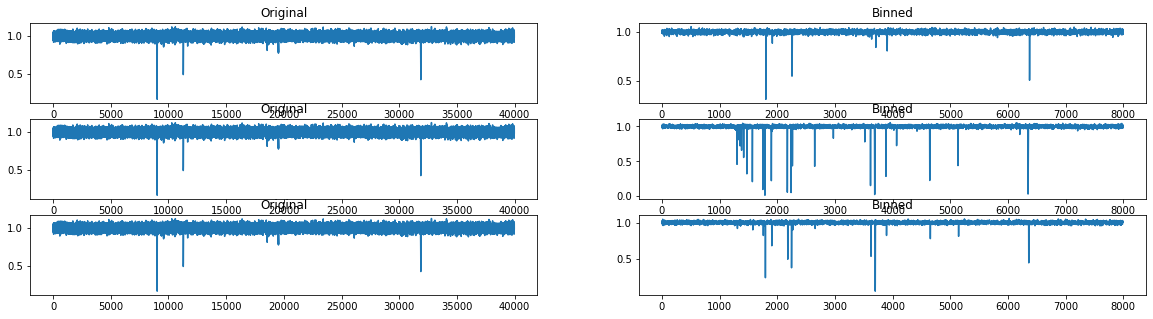

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(20, 5))

ax[0, 0].plot(x_train[0]);
ax[0, 0].set_title("Original");
ax[0, 1].plot(rebin_x_train[0]);
ax[0, 1].set_title("Binned");

ax[1, 0].plot(x_train[0]);
ax[1, 0].set_title("Original");
ax[1, 1].plot(rebin_x_train[100]);
ax[1, 1].set_title("Binned");

ax[2, 0].plot(x_train[0]);
ax[2, 0].set_title("Original");
ax[2, 1].plot(rebin_x_train[1000]);
ax[2, 1].set_title("Binned");

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

After a few experiments, a 90-10 split (90% training, 10% validation) was chosen.

In [ ]:
concat_data = np.vstack([x_train, x_val])
total = concat_data.shape[0]
np.random.shuffle(concat_data)
np.random.seed(0)
train_data, val_data = torch.from_numpy(concat_data[:int(total*0.9),:]), torch.from_numpy(concat_data[int(total*0.9):,:])

train_dataset = torch.utils.data.TensorDataset(train_data)
val_dataset = torch.utils.data.TensorDataset(val_data)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=8, shuffle=True
)

In [ ]:
len(train_dataset), len(val_dataset)

(6750, 750)

In [ ]:
# Custom tanh activation

# Light intensity is non-negative, hence we enforce this restriction on the reconstructed spectra, too, by . 
# This helps to improve model performance.
def custom_tanh(x, target_min=0, target_max=None):
    '''
    For given max and min values, return tanh activation with values in this range

    Inputs:
    - x: values to be transformed (np.array)
    - target_min: minimum value of tanh function (float)
    - target_max: max value of tanh function (float)

    Returns:
    - x transformed by tanh activation (np.array)
    '''
    tanh_ = nn.Tanh()
    x_02range = tanh_(x) + 1  # x mapped into range(0,2)
    scale = (target_max - target_min) / 2.  # calculate target range of transformed x

    return x_02range * scale + target_min

# Specify custom decoder layer
max_val = x_train.max().max()
# create custom tanh activation by specifying max value allowed for reconstructions
custom_tanh_activation = lambda x: custom_tanh(x, target_max=max_val)

class CustomTanh(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return custom_tanh_activation(x)

In [ ]:
class AddDim(nn.Module):
  """Adds a dimension to a PyTorch tensor at the end."""
  def __init__(self, *args):
    super().__init__()

  def forward(self, x):
    return x[:, :, None]

class ReBin(nn.Module):
  """Rebins input spectra with a given window size, n."""
  def __init__(self, *args):
    super().__init__()

  def forward(self, x, n=4):
    l = []
    for xx in x:
      ids = torch.arange(xx.size()[0]) // n
      ids = ids.to(device)
      l.append(torch.bincount(ids, xx) / torch.bincount(ids))
    return torch.stack(l)[:, :, None]

class Autoencoder(nn.Module):
  def __init__(self, latent_dim=6):
    super().__init__()
    self.latent_dim = latent_dim

    self.encoder = nn.Sequential(
        ReBin(),
        nn.Conv1d(9994, 4096, kernel_size=1),
        nn.BatchNorm1d(4096),
        nn.LeakyReLU(0.01),
        nn.Conv1d(4096, 1024, kernel_size=1),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.01),
        nn.Dropout(0.1),
        nn.Conv1d(1024, 256, kernel_size=1),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(0.01),
        nn.Dropout(0.1),
        nn.Conv1d(256, 32, kernel_size=1),
        nn.Flatten(),
        nn.Linear(32, self.latent_dim)
    )

    self.decoder = nn.Sequential(
        nn.Linear(self.latent_dim, 32),
        AddDim(),
        nn.ConvTranspose1d(32, 256, kernel_size=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose1d(256, 1024, kernel_size=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose1d(1024, 4096, kernel_size=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose1d(4096, 9994, kernel_size=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose1d(9994, 39974, kernel_size=1),
        CustomTanh()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

LATENT_DIM = 6
model = Autoencoder(latent_dim=LATENT_DIM)
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): ReBin()
    (1): Conv1d(9994, 4096, kernel_size=(1,), stride=(1,))
    (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv1d(4096, 1024, kernel_size=(1,), stride=(1,))
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv1d(256, 32, kernel_size=(1,), stride=(1,))
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=32, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): AddDim()
    (2): ConvTranspose1d(32, 25

In [ ]:
dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataloader.dataset), 'val': len(val_dataloader.dataset)}

In [ ]:
def reconstr_loss(original_spectra, reconstructed_spectra, latent_dim, train_val=True):
  '''Function to calculate reconstruction loss.

  Inputs:
  - original_spectra (np.array): original spectra.
  - reconstructed_spectra (np.array): reconstruction of the original spectra from the latent representation.
  - latent_dim (integer): size of the latent space.

  Returns:
  - reconstruction loss with added penalty for the latent space size
  '''

  penalty = 0.00003
  penalty2 = 5*0.00003

  if train_val:
    criterion = nn.MSELoss()
    mse_loss = criterion(original_spectra, reconstructed_spectra)
  else:
    mse_loss = mean_squared_error(original_spectra, reconstructed_spectra, squared=True)
  loss_penalized = mse_loss + latent_dim*penalty + penalty2*(latent_dim > 6)

  return loss_penalized

optimizer = torch.optim.Adam(
    model.parameters(), lr=6e-4, weight_decay=1e-5,
)
num_epochs = 40
# lambda1 = lambda epoch: 0.55 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)

In [ ]:
grad_clip = None  # Using gradient clipping gave slightly higher test errors, so we set it to None.
def train_model(model, dataloaders, optimizer, scheduler=None, num_epochs=25, grad_clip=None):
    epochs_no_improve = 0  # Track how many epochs with no decrease in validation loss
    n_epochs_stop = 5  # Stop if no decrement in validation loss after 5 consecutive epochs.
    early_stop = False
    min_val_loss = np.Inf

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Train and validate for each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
            else:
                model.eval()   # Evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for spec in dataloaders[phase]:
              # Zero parameter gradients.
                optimizer.zero_grad()

                spec = spec[0].to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):    
                    recon = model(spec[:, :, None].float())
                    loss = reconstr_loss(recon.squeeze().float(), spec.float(), latent_dim=LATENT_DIM)

                    if phase == 'train':
                        loss.backward()
                        if grad_clip is not None:
                            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                        optimizer.step()

                    # statistics
                    running_loss += loss.item() * spec.size(0)

            if phase == 'val':
                scheduler.step(epoch_loss)

            epoch_loss = running_loss / dataset_sizes[phase]

            ### Early Stopping ###
            if phase == "val" and epoch_loss < min_val_loss:
                epochs_no_improve = 0
                min_val_loss = epoch_loss
            elif phase == "val" and epoch_loss >= min_val_loss:
                epochs_no_improve += 1
            
            if epoch > 5 and (epochs_no_improve == n_epochs_stop):
                print("Early stopping!")
                return train_losses, val_losses  # Way to come out of all nested loops
            
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
            print(f'{phase} Loss: {epoch_loss}')

            if phase == 'val' and epoch_loss == min_val_loss:  # Check for equality because we set min_val_loss = epoch_loss if indeed loss decreased.
                # Save best model weights in a file.
                print("Val loss decreased, saving model file")
                torch.save(model.state_dict(), 'autoencoder_model.pth')

        print()

    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_model(
    model, dataloaders, optimizer, scheduler=scheduler, num_epochs=num_epochs, grad_clip=grad_clip,
)

Epoch 0/39
----------


/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


train Loss: 0.007583322731709039
val Loss: 0.005106324171026548
Val loss decreased, saving model file

Epoch 1/39
----------
train Loss: 0.005274789218687349
val Loss: 0.004907094387958447
Val loss decreased, saving model file

Epoch 2/39
----------
train Loss: 0.005079108108938844
val Loss: 0.005065713907902439

Epoch 3/39
----------
train Loss: 0.005022978121276807
val Loss: 0.0050358996403714025

Epoch 4/39
----------
train Loss: 0.004925770521853809
val Loss: 0.00677622390538454

Epoch 5/39
----------
train Loss: 0.0048650413650881364
val Loss: 0.004653983899702629
Val loss decreased, saving model file

Epoch 6/39
----------
train Loss: 0.004817929227663963
val Loss: 0.004760170046240091

Epoch 7/39
----------
train Loss: 0.004802326634388279
val Loss: 0.005571856863796711

Epoch 8/39
----------
train Loss: 0.004701933607390081
val Loss: 0.004668299444640677

Epoch 9/39
----------
train Loss: 0.0046187974747132375
val Loss: 0.004549152788395683
Val loss decreased, saving model file

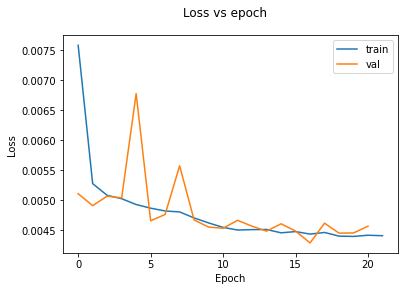

In [ ]:
fig, ax = plt.subplots(1, 1)

fig.suptitle("Loss vs epoch");
ax.plot(train_losses, label='train');
ax.plot(val_losses, label='val');
ax.set_ylabel("Loss");
ax.set_xlabel("Epoch");
ax.legend()
plt.savefig("autoencoder_loss.png", bbox_inches='tight', dpi=500)

In [ ]:
def load_model(path='autoencoder_model.pth'):
  model = Autoencoder(latent_dim=6)
  model.load_state_dict(torch.load(path))
  return model

In [ ]:
# from IPython.display import FileLink
# FileLink("autoencoder_model.pth")

In [ ]:
"""
Model can be found here: https://drive.google.com/file/d/1aXmuLb2D1eTTdj7C6GPTKHQN8iRsDJHB/view?usp=sharing

###
The below code assumes that the model file is loaded into the current session in the current working directory.
###

"""
model_file = 'autoencoder_model.pth'

# Define functions
def reduce_dimensionality(x_test, mode='test', device='cpu'):
  x_test_tensor = torch.from_numpy(x_test)
  test_dataset = torch.utils.data.TensorDataset(x_test_tensor)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

  model = load_model(path=model_file)
  model.to(device)
  if mode == 'test':
    model.eval()

  encoded_reprs = []
  for spec in test_dataloader:
    spec = spec[0].to(device)
    encoded = model.encoder(spec[:, :, None].float())
    encoded_reprs.append(encoded)

  final_encoded = np.vstack([encoded_reprs[i].cpu().detach().numpy() for i in range(len(encoded_reprs))]).squeeze()
  return final_encoded

def calculate_reconstructions(latent_data, mode='test', device='cpu'):
  model = load_model(path=model_file)
  model.to(device)
  if mode == 'test':
    model.eval()

  # Convert latent data into a PyTorch dataset for efficient iteration.
  latent_data_tensor = torch.from_numpy(latent_data)
  dataset = torch.utils.data.TensorDataset(latent_data_tensor)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=8)

  reconstructed = []
  for spec in dataloader:
    spec = spec[0].to(device)
    decoded = model.decoder(spec.float())
    reconstructed.append(decoded)

  reconstructed_all = np.vstack([reconstructed[i].cpu().detach().numpy() for i in range(len(reconstructed))]).squeeze()
  return reconstructed_all

In [ ]:
test_set_latent_encoding = reduce_dimensionality(x_test, device=device)

In [ ]:
test_set_reconstructions = calculate_reconstructions(test_set_latent_encoding, device=device)

In [ ]:
assert x_test.shape == test_set_reconstructions.shape, "Original and reconstructed shapes do not match!"  # Ensure reconstructions are of correct shape.
assert np.all(test_set_reconstructions >= 0), "Reconstructed spectrum has negative values, may lead to higher reconstruction loss!"  # Ensure output is non-negative.

In [ ]:
reconstr_loss(x_test, test_set_reconstructions, latent_dim=test_set_latent_encoding.shape[1], train_val=False)

0.004065272660012346

The loss on the test set is 0.004065272660012346. Below, some sample reconstructions are shown.

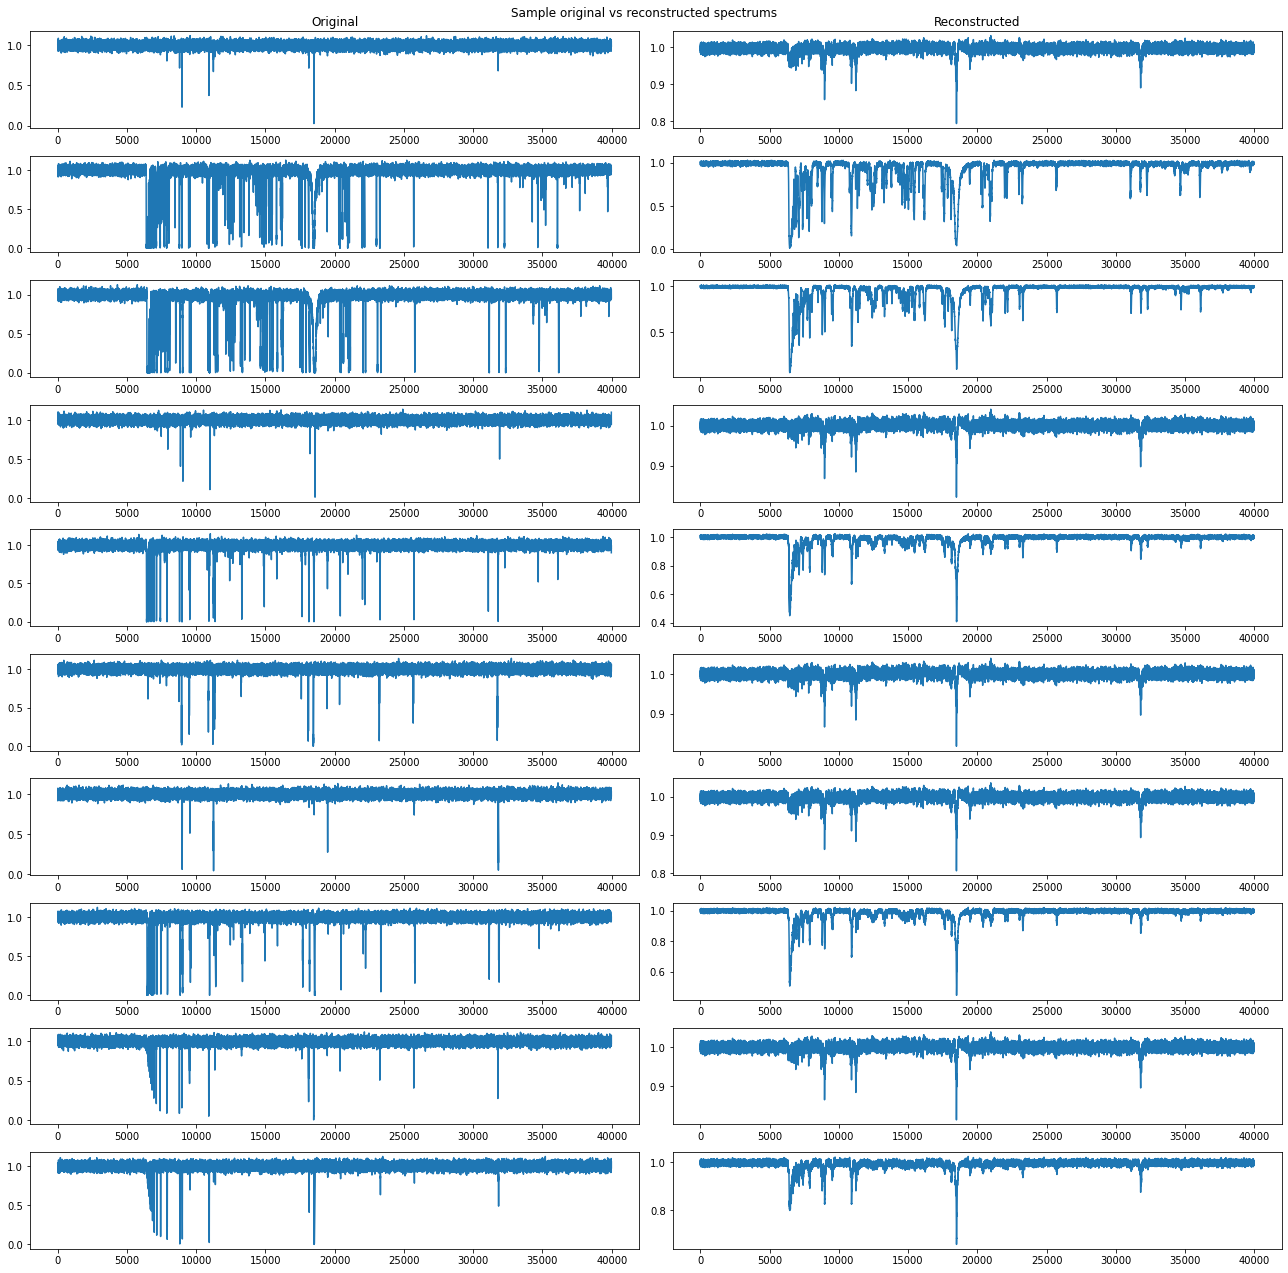

In [ ]:
rows = 10
fig, ax = plt.subplots(rows, 2, figsize=(18, 18))
fig.suptitle("Sample original vs reconstructed spectrums")

for i in range(rows):
    if i == 0:
        ax[i, 0].set_title("Original")
        ax[i, 1].set_title("Reconstructed")
    ax[i, 0].plot(x_test[i])
    ax[i, 1].plot(test_set_reconstructions[i])

plt.tight_layout()
plt.show()

In [ ]:
# from IPython.display import FileLink
# FileLink("./autoencoder_model.pth")

**Notes** (from experiments)
- `latent_dim = 6` resulted in the lowest reconstruction loss even though larger latent dimensions had a larger penalty.
- A variational autoencoder was trained as an experiment (keeping the same hyperparameters as the above approach). However, it didn't improve the performance on the test set.
    - In this case, the loss function used was binary cross-entropy + kl-divergence, instead of the reconstruction loss defined in `reconstr_loss` above.
    - This was an interesting approach, since the VAE model tried to minimize a particular loss function whereas a totally different loss function was used to evaluate on the test set.
- GANs were trained but did not yield good results as well.
- The re-binning approach proved slightly helpful to achieve lower loss on the test set. Hence, it was used as a pre-processing step in this implementation.
- The idea of adding some noise to the reconstructions from the autoencoder model was tried.
    - The motivation for this was because the reconstructions were more or less very close to 1. Hence, adding some noise could give more realistic reconstructions.
    - For this, adding noise based on the signal-to-noise ratio (SNR) of the reconstructed spectra was attempted. However, it slightly increased the loss on the test set, but it might be worth experimenting more!
- Finally, projection methods like PCA, t-SNE, UMAP, etc. yielded the worst results.